# Demo: Pipeline with GraphSAGE

In [ ]:
!pip install inductiveGRL 

Two global parameters need to be defined for this pipeline. The embedding size of graphsage's embeddings, and a boolean variable 'add additional data'. The latter is set to True so that the original transaction node data is added to the embeddings before classifications are made by our downstream classifier. It is advised to set this parameter to true, given that transaction features have proven to be very useful in traditional fraud detection. 

In [ ]:
# Global parameters:
embedding_size = 64
add_additional_data = True

### 1. Loading the Credit Card Transaction Data

Load numeric, artificially generated transaction data. 

In [ ]:
import pandas as pd 

url="https://raw.githubusercontent.com/Charlesvandamme/Inductive-Graph-Representation-Learning-for-Fraud-Detection/master/Demo/demo_ccf.csv"
df = pd.read_csv(url)


the `train_data` variable stores the data that will be used to construct graphs on which the representation learners can train. 
the `inductive_data` will be used to test the inductive performance of our representation learning algorithms.

In [ ]:
cutoff = round(0.6*len(df)) # first 60% of transactions are used for training, last 40% to test inductive capability
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [ ]:
print('The distribution of fraud for the train data is:\n', train_data['fraud_label'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['fraud_label'].value_counts())

The distribution of fraud for the train data is:
 0    482
1    164
Name: fraud_label, dtype: int64
The distribution of fraud for the inductive data is:
 0    327
1    103
Name: fraud_label, dtype: int64


### 2. Construct the Credit Card Transaction Network

nodes, edges and features are passed to the GraphConstruction constructor. Note that client and merchant node data hold a trivial attribute with value 1. This because we want all the relevant transaction data to reside at the transaction nodes and StellarGraph's current HinSAGE implementation requires all nodes to have features. 

In [ ]:
from inductiveGRL.graphconstruction import GraphConstruction

transaction_node_data = train_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1).drop('index', axis=1)
client_node_data = pd.DataFrame([1]*len(train_data.client_node.unique())).set_index(train_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(train_data.merchant_node.unique())).set_index(train_data.merchant_node.unique())

nodes = {"client":train_data.client_node, "merchant":train_data.merchant_node, "transaction":train_data.index}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 1525, Edges: 1292

 Node types:
  transaction: [646]
    Features: float32 vector, length 111
    Edge types: transaction-default->client, transaction-default->merchant
  client: [533]
    Features: float32 vector, length 1
    Edge types: client-default->transaction
  merchant: [346]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [646]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [646]
        Weights: all 1 (default)
        Features: none


## 2.1. Train GraphSAGE

HinSAGE, a heterogeneous implementation of the GraphSAGE framework is trained with user specified hyperparameters.

In [ ]:
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

#GraphSAGE parameters
num_samples = [2,32]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['fraud_label'], batch_size=5, epochs=10)

Epoch 1/10
104/104 [==============================] - 1s 10ms/step - loss: 0.5797 - val_loss: 0.5616
Epoch 2/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5695 - val_loss: 0.5617
Epoch 3/10
104/104 [==============================] - 1s 7ms/step - loss: 0.5707 - val_loss: 0.5607
Epoch 4/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5685 - val_loss: 0.5602
Epoch 5/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5691 - val_loss: 0.5602
Epoch 6/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5688 - val_loss: 0.5604
Epoch 7/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5698 - val_loss: 0.5604
Epoch 8/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5683 - val_loss: 0.5607
Epoch 9/10
104/104 [==============================] - 1s 7ms/step - loss: 0.5685 - val_loss: 0.5602
Epoch 10/10
104/104 [==============================] - 1s 6ms/step - loss: 0.5694 - val_loss: 0.560

## 2.2. Inductive Step GraphSAGE

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [ ]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

For the inductive step, we need to add the new, unseen transactions to the graph. Because the current StellarGraph implementation does not support adding nodes and edges to an existing stellargraph object, we create a new graph that contains all the nodes from the train graph in addition to the new nodes.

In [ ]:
transaction_node_data = inductive_graph_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1)
client_node_data = pd.DataFrame([1]*len(inductive_graph_data.client_node.unique())).set_index(inductive_graph_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(inductive_graph_data.merchant_node.unique())).set_index(inductive_graph_data.merchant_node.unique())

nodes = {"client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node, "transaction":inductive_graph_data.index}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 2444, Edges: 2152

 Node types:
  transaction: [1076]
    Features: float32 vector, length 111
    Edge types: transaction-default->client, transaction-default->merchant
  client: [872]
    Features: float32 vector, length 1
    Edge types: client-default->transaction
  merchant: [496]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction

 Edge types:
    merchant-default->transaction: [1076]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [1076]
        Weights: all 1 (default)
        Features: none


The inductive step applies the previously learned (and optimized) aggregation functions, part of the `trained_hinsage_model`. We also pass the new graph S and the node identifiers (inductive_data.index) to the inductive step. 

In [ ]:
inductive_emb = hinsage.inductive_step_hinsage(S, trained_hinsage_model, inductive_data.index, batch_size=5)

86/86 [==============================] - 0s 4ms/step


### 4. Classification: predictions based on inductive embeddings

Select your preferred classification model

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [ ]:
train_labels = train_data['fraud_label']

if add_additional_data is True:
    train_emb = pd.merge(train_emb, train_data.loc[train_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)
    inductive_emb = pd.merge(inductive_emb, inductive_data.loc[inductive_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)

    baseline_train = train_data.drop('fraud_label', axis=1)
    baseline_inductive = inductive_data.drop('fraud_label', axis=1)

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_emb, train_labels)
predictions = classifier.predict_proba(inductive_emb)


### 5. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall curves. 

Average precision-recall score XGBoost: 0.8744394809
Average precision-recall score XGBoost: 0.8225008566


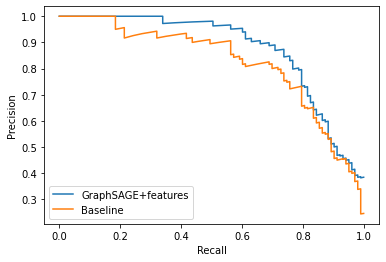

In [ ]:
from inductiveGRL.evaluation import Evaluation
inductive_labels = df.loc[inductive_emb.index]['fraud_label']

graphsage_evaluation = Evaluation(predictions, inductive_labels, "GraphSAGE+features") 
graphsage_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()